In [1]:
import csv
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor

filePath = 'C:\\Users\\moria\\OneDrive\\Universität\\Bachelor\\Project\\KubernetesScheduler\\co2_prediction\\Germany_CO2_Signal_2018.csv'
co2_emission_column = 3
unix_timestamp_column = 1

df = pd.DataFrame
a = 0
time = []
emission = []
timezone_unix_factor = 3600 # factor is necessary, as the unix timestamp is not standard compliant as timezone is set to UTC + 1
with open(filePath, 'r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    next(lines)  # skip the label field
    for row in lines:
        a = a + 1
        day = datetime.datetime.fromtimestamp(
            int(row[unix_timestamp_column]) - timezone_unix_factor)  # correction as timestamp is UTC not UTC + 1
        time.append(day)
        try:
            emission.append(float(row[co2_emission_column]))
        except:
            emission.append(None)
df = pd.DataFrame(list(zip(time, emission)), columns=['Date', 'y'])


In [2]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop_duplicates(subset=['Date'])

df = df.set_index('Date')
df = df.asfreq('H')
df = df.interpolate('ffill')

In [3]:
df.head()

,y
Date,
2018-01-01 00:00:00,190.279573
2018-01-01 01:00:00,189.292435
2018-01-01 02:00:00,188.811144
2018-01-01 03:00:00,188.936690
2018-01-01 04:00:00,188.617030


<AxesSubplot:xlabel='Date'>

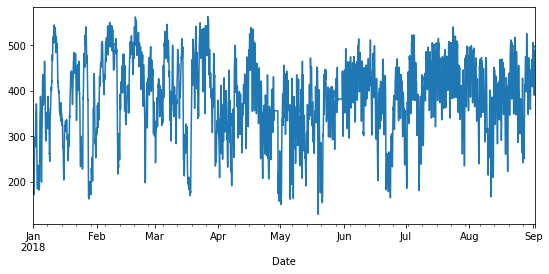

In [8]:
steps = 24
offset = 24*60
df = df[:-offset]
data_train = df[:-steps]
data_test_final = df[-steps:]
fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
#data_test['y'].plot(ax=ax, label='test')
#ax.legend()

In [22]:
#Ger 15 lags, 6 n_estim, 25 depth  - 0.056144845921992086 
#Fra 3 lags, 11 estim, 25 depth - 3.9348203480789237
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 14
             )
forecaster.fit(y=data_train['y'])

In [23]:
predictions = forecaster.predict(steps=steps)
print(predictions.head(5))

2018-09-02 00:00:00    450.005851
2018-09-02 01:00:00    440.737271
2018-09-02 02:00:00    435.757322
2018-09-02 03:00:00    430.456960
2018-09-02 04:00:00    429.655569
Freq: H, Name: pred, dtype: float64


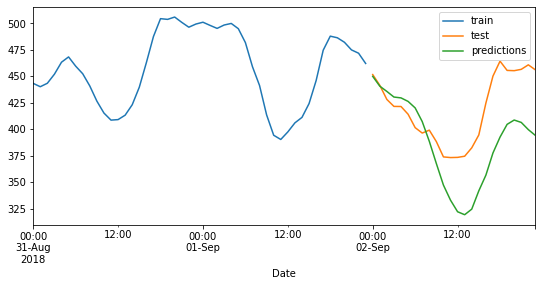

In [26]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train[-steps*2:]['y'].plot(ax=ax, label='train')
data_test_final['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [27]:
error = mape(data_test_final['y'], predictions)
print(error)

0.08607081439121682
